Joshua Andres Grajales

#### Wesleyan University ASTR 221

# Problem Set 5.2: Simulating dynamical friction

In this problem set, we will simulate the Large Magellanic Cloud's (LMC) descent towards the center of the Milky Way's dark matter halo under the influence of dynamical friction.

There are two forces at play here (gravity and dynamical friction), whose accelerations we will have to calculate independently:

$$ \vec{a}_{\rm total} = \vec{a}_{\rm g} + \vec{a}_{\rm df} $$

In [114]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120  
from math import pi

## Setting up a circular orbit: Gravity only (18 points)

Let's start simple by considering only the influence of gravity, and set the LMC up on a stable circular orbit.  This is similar to the exercise from the tutorial, with initial conditions
$$\vec{x}_0 = (x_0, y_0) = (0, r_0)$$
$$\vec{v}_0 = (v_{x,0}, v_{y,0}) = (\sqrt{GM(<r_0)/r_0}, 0)$$ 
and acceleration
$$\vec{a}_{\rm g} = -\frac{GM(<r)}{r^2} \hat{r}.$$

Unlike in the tutorial, the mass is not concentrated in a point at $r=0$, but is distributed in an NFW profile.  (For the sake of simplicity, we are going to ignore the stellar and gaseous components of the galaxy and only consider the dark matter halo.)  This means that the enclosed mass $M(<r)$ will be a function of radius, as it is an *integral* over the NFW density profile from 0 to $r$,
$$ M(<r) = \int_0^r \rho_{\rm NFW}(r') 4 \pi r'^2 dr'. $$

The code block below contains three functions:
- Our old friend ```int_trapezoid()``` which performs numerical integration using the trapezoid method
- A function ```NFW_MW()``` which gives the density of the dark matter halo of the Milky Way at the given radius
- A function ```Menc_MW()``` which will calculate the mass of dark matter enclosed at the given radius

The first two functions are already complete.  **Finish the last function to perform the integral above.**

Note: in the functions below, and in the entire assignment, we will use units of solar masses for mass, kpc for distance, and Myr for time.

In [115]:
# Approximates the integral of the function y given samples at points x
def int_trapezoid(x,y):
    deltax = x[1] - x[0]
    return (np.sum(y) - y[0]/2 - y[-1]/2)*deltax

# Calculates the density (in Msun/kpc^3) at radius r (in kpc) of the 
#    dark matter halo of the Milky Way as described by an NFW profile
def NFW_MW(r):
    rho0 = 7.e-3 * (1e3)**3  # Msun/kpc^3, central density of MW NFW profile
    rs = 20. # kpc, scale radius of MW NFW profile
    
    return rho0/(r/rs)/(1+r/rs)**2

# Approximates the mass (in solar masses) of the Milky Way's 
#    dark matter halo enclosed within radius r (in kpc) 
def Menc_MW(r):  
    # Create high-resolution array of radii representing equally-spaced spherical shells from 0 to r
    r_hr = np.linspace(0,r,201)[1:]-(r/200./2.)
    
    # YOUR CODE HERE: Use r_hr, NFW_MW() and int_trapezoid() to calculate the enclosed mass at r
    # follow the formula described above, independent var (x) is radius, dependent var is the integrand
    Menc = int_trapezoid(r_hr, NFW_MW(r_hr)*4*np.pi*r_hr**2)
    
    return Menc

Now that you have a function for the enclosed mass, you have everything needed to calculate the gravitational acceleration.  **Complete the function below** which calculates $\vec{a}_g$.  

(Note: this will be very similar to the function from the tutorial except that it should call ```Menc_MW()``` to get the mass.  I have given you the gravitational constant in the appropriate units.)

In [116]:
# Calculates the acceleration (in kpc/Myr^2) felt by an object at location xvec (in kpc)
#    with respect to the center of the Milky Way's dark matter halo due to 
#    the gravitational force exerted by the enclosed mass
def accel_grav_MW(xvec):
    G = 4.49e-12  # kpc^3 / (Msun Myr^2), gravitational constant
    
    # YOUR CODE HERE
    # follow formula description above
    r = np.sqrt(np.sum(xvec**2))
    rhat =xvec/r
    avec_grav = -1*G*Menc_MW(r)/r**2 * rhat
    
    return avec_grav

Finally, all we need to do is set the initial conditions!  Given the values below for the gravitational constant and the initial radius of the LMC (50 kpc), **set** $\vec{x}_0$ and $\vec{v}_0$ (in kpc and kpc/Myr respectively).

In [117]:
# Set mass of central body and orbital radius
G = 4.49e-12  # kpc^3 / (Msun Myr^2), gravitational constant
R0 = 50.     # kpc, initial radius of the LMC

# YOUR CODE HERE: Set initial conditions, follow description above
x0 = np.array([0,R0])
v0 = np.array([np.sqrt(G*Menc_MW(R0)/R0),0])

Below is the second-order Runge-Kutta method we developed in the tutorial.  Just execute this block (and read it over for the sake of your future self) - no modifications necessary (yet)!

In [118]:
def runge_kutta_2(x0, v0, afunc, dt, tfinal, *aargs):
    ''' Uses the 2nd-order Runge-Kutta method to evolve a system from an initial state (x0, v0) 
        according to the acceleration given by afunc.
        
        Input
        =====
        x0 (array, [Ndim]) : Initial n-dimensional position, e.g. (x), (x,y), or (x, y, z)
        v0 (array, [Ndim]) : Initial velocities (same shape as x0)
        afunc (function)   : Function of the form afunc(xvec, aargs) which gives dv/dt
        dt (scalar)        : Timestep
        tfinal (scalar)    : Time at which to halt calculation
        aargs (optional, tuple) : Additional arguments to pass through to afunc
        
        Output
        ======
        x (array, [Nsteps, Ndim]) : Array of positions at each timestep
        v (array, [Nsteps, Ndim]) : Array of velocities at each timestep
        t (array, [Nsteps])       : Time at each timestep
    '''

    # Initialize lists of x, v, and t
    x = [np.copy(x0)]
    v = [np.copy(v0)]
    t = [0.]

    xn = np.copy(x0)
    vn = np.copy(v0)
    tn = 0.
    while tn < tfinal:
        # Calculate dv/dt based on x
        avec = afunc(xn, *(aargs))

        # Find x and v at t + dt/2
        xhalf = xn + vn*dt/2
        vhalf = vn + avec*dt/2

        # Update the state of the system according to the derivatives at t + dt/2
        avec_half = afunc(xhalf, *(aargs))

        xn += vhalf*dt
        vn += avec_half*dt
        tn += dt

        # Add updated state to lists
        x.append(np.copy(xn))
        v.append(np.copy(vn))
        t.append(tn)

    return np.stack(x, axis=0), np.stack(v, axis=0), np.array(t)

Now all that's left to do is to run the simulation!  The code in the block below sets the timestep ```dt``` and the final time ```tfinal```, and plots a perfect circle of radius $r_0$.

**Run your simulation** from the initial conditions $(\vec{x}_0, \vec{v}_0)$ forward to $t_{\rm final}$ using the second-order Runge-Kutta method to estimate the gravitational acceleration, and **plot the resulting orbit**.  (It should lie on top of the circle!)

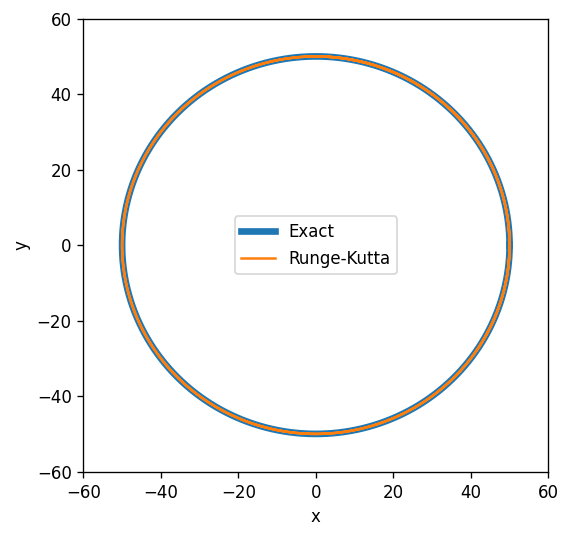

In [119]:
# Set timestep and duration
dt = 1.  # Myr
tfinal = 4000.  # Myr

fig, ax = plt.subplots(figsize=(5,5))

# Draws a circle of radius R0
ax.plot(R0*np.cos(np.linspace(0,2*pi,200)), R0*np.sin(np.linspace(0,2*pi,200)), lw=4, label='Exact')

# YOUR CODE HERE: Run the Runge-Kutta method and plot the resulting orbit
x,v,t=runge_kutta_2(x0, v0, accel_grav_MW, dt, tfinal)
ax.plot(x[:,0], x[:,1], label ='Runge-Kutta')
     
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.legend()

## Write a function for dynamical friction (12 points)

Having established the framework of the simulation, we can now introduce the additional force of dynamical friction.  Recall that
$$ \vec{a}_{\rm df} = -4 \pi G^2 \ln(\Lambda) \frac{M_{\rm obj} \rho(<v)}{|v|^2} \hat{v} $$
where $M_{\rm obj}$ is the mass of the moving object, $\rho$ is the density of the medium through which it is moving, $v$ is its speed with respect to that medium, and $\ln(\Lambda)$ depends on the system (where $\Lambda \sim 20$ for the LMC-MW system).

An important wrinkle is that $\rho(<v)$ is the density of the medium *which is moving more slowly than the object*.  This is a fraction of the overall density $f(<v)$ which depends on the distribution of velocities in the surrounding medium, $\rho(<v) = \rho~f(<v)$.  In reality this fraction is an integral over that distribution of velocities, but it can be approximated as 
$$ f(<v) \approx \frac{1}{(1+\sigma_{\rm DM}/|v|)^3} $$
where $\sigma_{\rm DM}$ is the characteristic speed of dark matter particles.  In this way, $a_{\rm df} \propto -v^{-2}$ when $v \gg \sigma_{\rm DM}$, but $a_{\rm df} \propto -v$ when $v \ll \sigma_{\rm DM}$ such that the acceleration is small in the low-speed limit.

**Finish implementing the function below** which calculates the acceleration due to dynamical friction experienced by an object in the vicinity of the Milky Way.  You can assume within the function that $\rho = \rho_{\rm NFW, MW}(r)/(1+\sigma_{\rm DM}/|v|)^3$ (where $\sigma_{\rm DM} = 0.1$ kpc/Myr is already defined for you) and $\Lambda = 20$, but should take $M_{\rm obj}$ as an argument of the function.

In [120]:
def accel_dynfric_MW(xvec, vvec, Mobj):
    ''' Calculates the gravitational acceleration felt by an object in the 
        vicinity of the Milky Way due to dynamical friction.
        
        Input
        =====
        xvec (array)  : Coordinate vector ([x, y[, z]]) giving the object's location
                        with respect to the center of the Milky Way in units of kpc
        vvec (array)  : Velocity vector ([vx, vy[, vz]]) giving the object's motion
                        with respect to the center of the Milky Way in units of kpc/Myr
        Mobj (scalar) : Mass of the object in units of Msun
        
        Output
        ======
        avec (array)  : Acceleration vector ([x, y[, z]]) resulting from the force of 
                        dynamical friction in units of kpc/Myr^2
    '''
    
    G = 4.49e-12  # kpc^3 / (Msun Myr^2), gravitational constant
    sigma_DM = 0.1  # kpc/Myr, characteristic speed of DM particles
    
    # YOUR CODE HERE
    vmag = np.sqrt(np.sum(vvec**2))
    vhat = vvec/vmag
    rho = NFW_MW(np.sqrt(np.sum(xvec**2)))/(1+sigma_DM/vmag)**3
    avec_dynfric = -4*np.pi*G**2*np.log(20)*Mobj * rho * vhat/vmag**2

    return avec_dynfric

To check your work, the code block below prints out the acceleration vectors from gravity and dynamical friction respectively for the LMC (with a mass of $M_{\rm obj} = 2 \times 10^{10}~{\rm M}_\odot$) at the initial position.  You should find that the gravitational acceleration is purely in the y-direction, while the dynamical friction acceleration is purely in the x-direction.

In [121]:
Mobj = 2.e10  # Msun, mass of the LMC

print(accel_grav_MW(x0))
print(accel_dynfric_MW(x0, v0, Mobj))

[-0.         -0.00067891]
[-2.78341409e-05 -0.00000000e+00]


## Modify the Runge-Kutta method (5 points)

Because the function for acceleration due to dynamical friction depends on the velocity of the object in addition to its position, we must (slightly) modify our function for advancing the simulation using the second-order Runge-Kutta method.  The function below defines the *combined* accelerations from both gravity and dynamical friction, and is the function that should be fed into the Runge-Kutta method.

In [122]:
# Function to calculate the combined acceleration from gravity and dynamical friction
def accel_total_MW(xvec, vvec, Mobj):
    return accel_grav_MW(xvec) + accel_dynfric_MW(xvec, vvec, Mobj)

The Runge-Kutta function below is copied directly from above.  **Modify the function** so that it will work with an acceleration function which takes both the position and velocity vectors as arguments.

In [123]:
def runge_kutta_2(x0, v0, afunc, dt, tfinal, *aargs):
    ''' Uses the 2nd-order Runge-Kutta method to evolve a system from an initial state (x0, v0) 
        according to the acceleration given by afunc.
        
        Input
        =====
        x0 (array, [Ndim]) : Initial n-dimensional position, e.g. (x), (x,y), or (x, y, z)
        v0 (array, [Ndim]) : Initial velocities (same shape as x0)
        afunc (function)   : Function of the form afunc(xvec, aargs) which gives dv/dt
        dt (scalar)        : Timestep
        tfinal (scalar)    : Time at which to halt calculation
        aargs (optional, tuple) : Additional arguments to pass through to afunc
        
        Output
        ======
        x (array, [Nsteps, Ndim]) : Array of positions at each timestep
        v (array, [Nsteps, Ndim]) : Array of velocities at each timestep
        t (array, [Nsteps])       : Time at each timestep
    '''

    # Initialize lists of x, v, and t
    x = [np.copy(x0)]
    v = [np.copy(v0)]
    t = [0.]
    
    xn = np.copy(x0)
    vn = np.copy(v0)
    tn = 0.
    
    # YOUR CODE HERE: Modify the loop to work with acceleration functions that
    #                 depend on both position and velocity
    while tn < tfinal:
        # Calculate dv/dt based on x
        avec = afunc(xn, vn, *(aargs))
        
        # Find x and v at t + dt/2
        xhalf = xn + vn*dt/2
        vhalf = vn + avec*dt/2
        
        # Update the state of the system according to the derivatives at t + dt/2
        avec_half = afunc(xhalf, vhalf, *(aargs))
        xn += vhalf*dt
        vn += avec_half*dt
        tn += dt
        
        # Add updated state to lists
        x.append(np.copy(xn))
        v.append(np.copy(vn))
        t.append(tn)

    return np.stack(x, axis=0), np.stack(v, axis=0), np.array(t)

## Run the simulation and plot the result! (4 points)

It's time to see whether your work has paid off!  As before, the code block below plots a perfectly circular orbit.  Run your Runge-Kutta algorithm using the combined gravity + dynamical friction acceleration and overplot the resulting orbit.

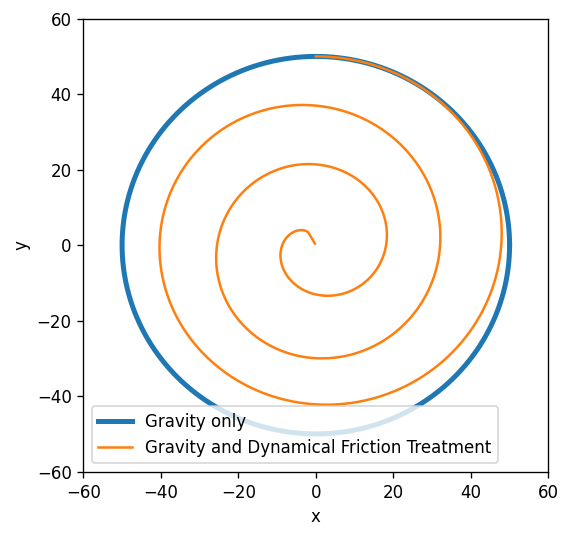

In [124]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(R0*np.cos(np.linspace(0,2*pi,200)), R0*np.sin(np.linspace(0,2*pi,200)), lw=3, label='Gravity only')

# YOUR CODE BELOW: Run the simulation and plot the result
x,v,t = runge_kutta_2(x0, v0, accel_total_MW, dt, tfinal, Mobj)
ax.plot(x[:,0], x[:,1], label = 'Gravity and Dynamical Friction Treatment')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.legend()

**(1 point)**: How difficult was this assignment?  Did you feel prepared to take it on, or was it totally bewildering?

5/10 coding was not very difficult but the physical implications and how they maifested in our plots were cool. As always, the documentation and problem descriptions helped me understand the physical relevance of each calculation. 

READ BELOW FOR COOL FACTOID

In class on Wednesday I approached you to talk about an error I was getting when I passed R0 (in my initial conditions) as an integer,50, as opposed to a float, 50. : 

**UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'**

I did some quick research and found that the issue was being generated because I was trying to modify the original xn array (in-place) in line 40 of the (first) Runge-Kutta function. **xn+=vhalf x dt** is in place where as **xn = xn + vhalf x dt** creates a new array.

A quirk of numpy but a noteworthy distinction. 

https://stackoverflow.com/questions/52868835/im-getting-a-typeerror-for-a-b-but-not-b-a-numpy


**My reflection of the course**

I am a commuter student. It takes about 30 minutes for me to get to school everyday by car. Your course was the only on campus commitment I had for Monday and Wednesdays. Despite the total one hour commute, I can say every minute of driving was worth it. **I really enjoyed your course**. 

I found myself particularly engaged by the material, despite having seen much of it in previous astronomy courses, because your homeworks allowed me to engage with the material from **both** an analytical and computational perspective. Your extensive documentation and coding tutorials equipped me with practical and cool computational and analytical techniques. If you have any other coding material/tutorials from previous courses you've taught please share!

Thank you for the wonderful semester. 

Best